In [ ]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('white')
import os
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
from bokeh.io import output_notebook
output_notebook()

In [ ]:
good_stations = [1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1018, 1045, 1046, 1047, 1021, 1049, 1050, 1570, 1019, 1066, 1067, 1068, 1590, 1085, 1020, 1610, 1611, 1612, 1613, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1128, 1129, 1130, 1138, 1139, 1140, 1141, 1142, 1144, 1145, 1231, 1232, 1233, 1234, 1235, 1236, 1753, 1772, 1797, 1306, 1307, 1346, 1347, 1386, 1387, 1406, 1407, 1426, 1446, 1447, 1467, 1468, 1487, 1507, 1508, 1510, 1001, 1002, 1003, 1004, 1005, 1006, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1528, 1529, 1530, 1531, 1532, 1017, 1022, 1023]

In [ ]:
#Get number of NaN's
from bokeh.plotting import figure, show
from bokeh.layouts import row, column

for i,id in enumerate(good_stations):
    filter_condition = ('station_ID', '==', id)
    df = pd.read_parquet('s3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet',engine='pyarrow',filters=[filter_condition])#,columns=['Variable', 'UTC_Start', 'Volumetric','Temperature','Precipitation','Wetness2','FlagBit'])
    print("Station: ",id)
    print("No. of rows with variable column NaN: ",df.Variable.isna().sum())
    print("No. of rows with FlagBit column NaN: ",df.FlagBit.isna().sum())
    print("No. of rows with Volumetric column NaN: ",df.Volumetric.isna().sum())
    df = df[df.Volumetric.isna()]
    print("Dist. of Volumetric NaNs against FlagBit : ",df.FlagBit.value_counts(dropna=False))       #len(df[(df.FlagBit==17.0) | (df.FlagBit==16.0) | (df.FlagBit==1.0)]))
    #print(df.Variable.value_counts(dropna=False))
    #df[(df.Variable.isna())].head(10)
    
    #df.Variable.astype('str')
    #s1 = figure(title=f'Station: {id} ',width=1250, height=450, background_fill_color="#fafafa",x_axis_type="datetime")
    #s1.scatter("UTC_Start", "Variable", source=df,size=4, alpha=0.5, marker="circle")
    #show(s1)
    #sns.scatterplot(data=df,x="UTC_Start",y='Variable')
    #plt.show()
    del [df]
    #break

In [ ]:
df[(df.Variable.isna())].head(10)

In [ ]:
#FlagBit columns used for flag
parquet_file = pq.ParquetFile('s3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet')
df = pd.read_parquet('s3://uscrn-soilmoisture-ml/shiva/hydra/parquet/preprocessed_1.parquet',engine='pyarrow',columns=['FlagBit','UTC_Start'])
df.FlagBit.value_counts(dropna=False)

In [ ]:
import numpy as np
arr = df.FlagBit.values.astype(np.ushort)

In [ ]:
df.FlagBit.values.dtype

In [ ]:
print(np.unique(arr))

In [ ]:
#Check if all stations have all sensors 
for id in good_stations:
    filter_condition = ('station_ID', '==', id)
    df = pd.read_parquet('s3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet',engine='pyarrow',filters=[filter_condition])
    print(id)
    print(df.Variable.unique())

## Creating cleaned version of raw data
- Keep only good stations
- The rows with Variable/FlagBit NaN are dropped. (this corresponds to no sensor present)
- remaining Rows with Volumetric as NaN are filled with -9999
- Create a Flag column such that, if FlagBit is 0, Flag is 0, If FlagBit is 32,33 (32 + 1),48 (32+16),49 (32+16+1) 	then Flag is 1, else Flag is 2(auto Flag) 
- Split the data into train, validation, test (approx 80-10-10)
- Keep only Wetness_2 for precip
- Pivot the data to have 15 columns for volumetric, 1 for temparature, 1 for precip and 17 flag column
- add 2 additional flag columns for precip and temp and always keep it as 0s
- Drop the UTC_Start, station_ID

In [ ]:
# 0 -> Normal, 1 -> Manual flag, 2 -> auto flag
def any_flags(row):
    if row['FlagBit'] == 0.0:
        return 0
    elif (row['FlagBit'] == 32) or (row['FlagBit'] == 33) or (row['FlagBit'] == 48) or (row['FlagBit'] == 49):
        return 1
    else:
        return 2

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel,delayed

#source_parquet_file = 's3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet'

columns = ['station_ID','UTC_Start','Temperature','Wetness2','Precipitation','Variable','Volumetric','FlagBit']

def preprocess_and_save(id, output_path):
    print(id)
    filter_condition = ('station_ID', '==', id)
    df = pd.read_parquet('s3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet',engine='pyarrow',filters=[filter_condition])
    df.sort_values(by=['UTC_Start'], inplace=True)
    df.dropna(subset=['Variable'],inplace=True)
    #print(df.isna().sum())
    #Fill NaN's
    df.fillna({'Volumetric': -9999}, inplace=True)
    df['Flag'] = df.apply(lambda x: any_flags(x), axis=1)
    df_pivot = df.pivot(index=['station_ID','UTC_Start'],columns='Variable',values=['Temperature','Volumetric','Wetness2','Precipitation','Flag'])
    df_pivot.columns = df_pivot.columns.map('|'.join).str.strip('|')
    
    df_pivot['Temperature'] = df_pivot[list(df_pivot.filter(regex='^(Temperature\|)',axis=1).columns)].max(axis=1)
    df_pivot['Wetness2'] = df_pivot[list(df_pivot.filter(regex='^(Wetness2\|)',axis=1).columns)].max(axis=1)
    
    df_pivot['Precipitation'] = df_pivot[list(df_pivot.filter(regex='^(Precipitation\|)',axis=1).columns)].max(axis=1)
    
    df_pivot.drop(columns=list(df_pivot.filter(regex='^(Temperature\|)',axis=1).columns),inplace=True)
    df_pivot.drop(columns=list(df_pivot.filter(regex='^(Wetness2\|)',axis=1).columns),inplace=True)
    df_pivot.drop(columns=list(df_pivot.filter(regex='^(Precipitation\|)',axis=1).columns),inplace=True)
    
    df_pivot['Temperature|Flag'] = 0
    df_pivot['Wetness2|Flag'] = 0
    df_pivot['Precipitation|Flag'] = 0
    
    cols= ['Volumetric|sm1005', 'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050', 'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010', 'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100', 'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020', 'Volumetric|sm3050', 'Volumetric|sm3100']
    for col in cols:
        if col not in df_pivot.columns:
            df_pivot[col] = -9999
        df_pivot.fillna({col: -9999}, inplace=True)
    
    cols = ['Flag|sm1005','Flag|sm1010', 'Flag|sm1020', 'Flag|sm1050', 'Flag|sm1100','Flag|sm2005', 'Flag|sm2010', 'Flag|sm2020', 'Flag|sm2050','Flag|sm2100', 'Flag|sm3005', 'Flag|sm3010', 'Flag|sm3020','Flag|sm3050', 'Flag|sm3100']
    for col in cols:
        if col not in df_pivot.columns:
            df_pivot[col] = 2
        df_pivot.fillna({col: 2}, inplace=True)

    df_pivot.loc[df_pivot.Precipitation.isna(),'Precipitation|Flag'] = 2
    df_pivot.fillna({'Precipitation': -9999}, inplace=True)
    final_cols = ['Volumetric|sm1005',
       'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050',
       'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010',
       'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100',
       'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020',
       'Volumetric|sm3050', 'Volumetric|sm3100', 'Temperature', 'Wetness2', 'Precipitation', 'Flag|sm1005',
       'Flag|sm1010', 'Flag|sm1020', 'Flag|sm1050', 'Flag|sm1100',
       'Flag|sm2005', 'Flag|sm2010', 'Flag|sm2020', 'Flag|sm2050',
       'Flag|sm2100', 'Flag|sm3005', 'Flag|sm3010', 'Flag|sm3020',
       'Flag|sm3050', 'Flag|sm3100', 'Temperature|Flag', 'Wetness2|Flag', 'Precipitation|Flag']
    df_pivot = df_pivot[final_cols]
    #print(df_pivot.isna().sum())
    df_pivot.reset_index(inplace=True)
    print(output_path+f'{id}.parquet')
    #print(df_pivot[df_pivot['Precipitation|Flag'] == 2].head())
    #print(df_pivot[df_pivot['Precipitation|Flag']==2].head())
      
    #if i == 0:
        # Guess the schema of the CSV file from the first chunk
    parquet_schema = pa.Table.from_pandas(df=df_pivot).schema
    parquet_writer = pq.ParquetWriter(output_path+f'{id}.parquet', parquet_schema, compression='snappy')
        
    table = pa.Table.from_pandas(df_pivot, schema=parquet_schema)
    parquet_writer.write_table(table)
    
    del[df]
    del [df_pivot]
    
    parquet_writer.close()
#parquet_writer_valid.close()
#parquet_writer_test.close()

In [ ]:
import multiprocessing
output_path = 's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/raw_data/'
num_processes = multiprocessing.cpu_count()
# Create a pool of processes
with multiprocessing.Pool(processes=num_processes) as pool:
    pool.starmap(preprocess_and_save, [(id, output_path) for id in good_stations])
#merge_temp_files(output_path)

## Creating cleaned version of data with standardisation
NOTE: Each of these stetps is done on each station at a time
- Here the rows with Variable/FlagBit NaN are dropped. (this corresponds to no sensor present)
- remaining Rows with Volumetric as NaN are filled with -9999
- Create a Flag column such that, if FlagBit is 0, Flag is 0, If FlagBit is 32,33 (32 + 1),48 (32+16),49 (32+16+1) 	then Flag is 1, else Flag is 2(auto Flag
- Use Wetness1 as precip.
- pivot the data such that for a station at a timestamp, all volumetric values, temp and precip values are present in a row 	along with output flags for each value
- create a single column for temp and precip from pivoted columns
- add 2 additional flag columns for precip and temp and always keep it as 0
- Split the data into train, test, validation
- In pivoted dataframe, standardise the volumetric columns per station (MinMaxScaler)
- remove the timestamp and station columns. Finally 17 inp/17 outputs.)

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel,delayed

#source_parquet_file = 's3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet'

columns = ['station_ID','UTC_Start','Temperature','Wetness2','Precipitation','Variable','Volumetric','FlagBit']

def preprocess_and_save(id, output_path):
    print(id)
    filter_condition = ('station_ID', '==', id)
    df = pd.read_parquet('s3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet',engine='pyarrow',filters=[filter_condition])
    df.sort_values(by=['UTC_Start'], inplace=True)
    df.dropna(subset=['Variable'],inplace=True)
    #Fill NaN's
    df.fillna({'Volumetric': -9999}, inplace=True)
    df['Flag'] = df.apply(lambda x: any_flags(x), axis=1)
    df_pivot = df.pivot(index=['station_ID','UTC_Start'],columns='Variable',values=['Temperature','Volumetric','Wetness2', 'Precipitation', 'Flag'])
    df_pivot.columns = df_pivot.columns.map('|'.join).str.strip('|')
    
    df_pivot['Temperature'] = df_pivot[list(df_pivot.filter(regex='^(Temperature\|)',axis=1).columns)].max(axis=1)
    df_pivot['Wetness2'] = df_pivot[list(df_pivot.filter(regex='^(Wetness2\|)',axis=1).columns)].max(axis=1)
    df_pivot['Precipitation'] = df_pivot[list(df_pivot.filter(regex='^(Precipitation\|)',axis=1).columns)].max(axis=1)
    
    df_pivot.drop(columns=list(df_pivot.filter(regex='^(Temperature\|)',axis=1).columns),inplace=True)
    df_pivot.drop(columns=list(df_pivot.filter(regex='^(Wetness2\|)',axis=1).columns),inplace=True)
    df_pivot.drop(columns=list(df_pivot.filter(regex='^(Precipitation\|)',axis=1).columns),inplace=True)
    
    df_pivot['Temperature|Flag'] = 0
    df_pivot['Wetness2|Flag'] = 0
    df_pivot['Precipitation|Flag'] = 0
    
    cols= ['Volumetric|sm1005', 'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050', 'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010', 'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100', 'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020', 'Volumetric|sm3050', 'Volumetric|sm3100']
    for col in cols:
        if col not in df_pivot.columns:
            df_pivot[col] = -9999
        df_pivot.fillna({col: -9999}, inplace=True)
    
    cols = ['Flag|sm1005','Flag|sm1010', 'Flag|sm1020', 'Flag|sm1050', 'Flag|sm1100','Flag|sm2005', 'Flag|sm2010', 'Flag|sm2020', 'Flag|sm2050','Flag|sm2100', 'Flag|sm3005', 'Flag|sm3010', 'Flag|sm3020','Flag|sm3050', 'Flag|sm3100']
    for col in cols:
        if col not in df_pivot.columns:
            df_pivot[col] = 2
        df_pivot.fillna({col: 2}, inplace=True)

    df_pivot.loc[df_pivot.Precipitation.isna(),'Precipitation|Flag'] = 2
    df_pivot.fillna({'Precipitation': -9999}, inplace=True)
    
    #df_pivot.reset_index(drop=True, inplace=True)
    final_cols = ['Volumetric|sm1005',
       'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050',
       'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010',
       'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100',
       'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020',
       'Volumetric|sm3050', 'Volumetric|sm3100', 'Temperature', 'Wetness2', 'Precipitation','Flag|sm1005',
       'Flag|sm1010', 'Flag|sm1020', 'Flag|sm1050', 'Flag|sm1100',
       'Flag|sm2005', 'Flag|sm2010', 'Flag|sm2020', 'Flag|sm2050',
       'Flag|sm2100', 'Flag|sm3005', 'Flag|sm3010', 'Flag|sm3020',
       'Flag|sm3050', 'Flag|sm3100', 'Temperature|Flag', 'Wetness2|Flag', 'Precipitation|Flag']
    df_pivot = df_pivot[final_cols]
    #print(df_pivot.isna().sum())
    #tot = len(df_pivot)
    #train = int(tot*0.8)
    #valid = int(tot*0.9)
    #train_df = df_pivot.iloc[:train]
    #valid_df = df_pivot.iloc[train:valid]
    #test_df = df_pivot.iloc[valid:]

    #Standardisation

    cols= ['Volumetric|sm1005', 'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050', 'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010', 'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100', 'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020', 'Volumetric|sm3050', 'Volumetric|sm3100']
    for col in cols:
        scaler = MinMaxScaler()
        null_index = df_pivot[col] == -9999
        #null_index_valid = valid_df[col] == -9999
        #null_index_test = test_df[col] == -9999
        if len(df_pivot.loc[~null_index, [col]])!= 0:
            df_pivot.loc[~null_index, [col]] = scaler.fit_transform(df_pivot.loc[~null_index, [col]])
            '''
            if len(valid_df.loc[~null_index_valid, [col]]) !=0:
                valid_df.loc[~null_index_valid, [col]] = scaler.transform(valid_df.loc[~null_index_valid, [col]])
            if len(test_df.loc[~null_index_test, [col]]) != 0:
                test_df.loc[~null_index_test, [col]] = scaler.transform(test_df.loc[~null_index_test, [col]])
            '''
        
    #print("after")
    print(df_pivot.head())
    df_pivot.reset_index(inplace=True)
    print(output_path+f'{id}.parquet')
    #print(df_pivot[df_pivot['Precipitation|Flag'] == 2].head())
    #print(df_pivot[df_pivot['Precipitation|Flag']==2].head())
      
    #if i == 0:
        # Guess the schema of the CSV file from the first chunk
    parquet_schema = pa.Table.from_pandas(df=df_pivot).schema
    parquet_writer = pq.ParquetWriter(output_path+f'{id}.parquet', parquet_schema, compression='snappy')
        
    table = pa.Table.from_pandas(df_pivot, schema=parquet_schema)
    parquet_writer.write_table(table)
    
    del[df]
    del [df_pivot]
    
    parquet_writer.close()
#parquet_writer_valid.close()
#parquet_writer_test.close()

In [ ]:
import multiprocessing
output_path = 's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/standard_data/'
num_processes = multiprocessing.cpu_count()
# Create a pool of processes
with multiprocessing.Pool(processes=num_processes) as pool:
    pool.starmap(preprocess_and_save, [(id, output_path) for id in good_stations])

## Creating cleaned version of data with climatology preprocessing
For each time point in a year:
- For each month-day-hour value, sensor data for that value is take. If there is no measurement for those values (no readings at all including -9999) , climatology is not calculated (0,0,0)
- If there is some data, now a window of +- 7 days is taken for that point and data across all years within that window is taken in a temp dataframe
- If this temp dataframe if the number of values with -9999 is more than 50%, climatology is again not calculated (0,0,0)
- else the mean, standard deviation and count of these data points are calculated and stored in dictionary for this particuler month-day-hour key
- Finally for all data points without -9999 as value, the data is standardised with climatology values (data-mean/std). If the std is 0 (same measurements across for that time) or count is 0, 


In [ ]:
!pip install awswrangler

In [ ]:
from datetime import datetime, timedelta

def func(row,col,climatology_dict):
    if climatology_dict[row['preprocess_key']][2] == 0:
        return row[col]
    else:
        return (row[col] - climatology_dict[row['preprocess_key']][0])/climatology_dict[row['preprocess_key']][1]
    
def preprocessing(column, df, window):
    df.loc[:,['month']] = df['UTC_Start'].dt.month
    df.loc[:,['day']] = df['UTC_Start'].dt.day
    df.loc[:,['hour']] = df['UTC_Start'].dt.hour
    climatology_dict = {}
    td = timedelta(days=window)
    it_1 = timedelta(days=1)
    start_date = datetime.strptime('01-01-00','%m-%d-%H')
    end_date = datetime.strptime('12-31-23','%m-%d-%H')
    print(start_date.strftime('%m-%d-%H'))
    print(df.isnull().sum())
    it = timedelta(hours=1)
    while start_date <= end_date:
        window_date_start = start_date - td
        temp_df = pd.Series()
        while window_date_start <= start_date + td:
            #print(df[(df.month == window_date_start.month) & (df.day == window_date_start.day) & (df.hour == window_date_start.hour)].Volumetric)
            if not temp_df.empty:
                temp_df = pd.concat([df[(df.month == window_date_start.month) & (df.day == window_date_start.day) & (df.hour == window_date_start.hour)][column], temp_df], ignore_index=True)
            else:
                temp_df = df[(df.month == window_date_start.month) & (df.day == window_date_start.day) & (df.hour == window_date_start.hour)][column]
            window_date_start = window_date_start + it_1
        if len(temp_df[temp_df!= -9999]) < 0.5*len(temp_df):
            climatology_dict[start_date.strftime('%m-%d-%H')] = (0,0,0)
        else:
            temp_df = temp_df[temp_df!= -9999]
            temp_df = temp_df[~temp_df.isnull()]
            climatology_dict[start_date.strftime('%m-%d-%H')] = (temp_df.mean(), temp_df.std(), len(temp_df))
        start_date = start_date + it
        del [temp_df]

    #For Leap year
    start_date = datetime.strptime('2012-02-29-00','%Y-%m-%d-%H')
    end_date = datetime.strptime('2012-02-29-23','%Y-%m-%d-%H')
    it = timedelta(hours=1)
    while start_date <= end_date:
        window_date_start = start_date - td
        temp_df = pd.Series()
        while window_date_start <= start_date + td:
            #print(df[(df.month == window_date_start.month) & (df.day == window_date_start.day) & (df.hour == window_date_start.hour)].Volumetric)
            temp_df = pd.concat([df[(df.month == window_date_start.month) & (df.day == window_date_start.day) & (df.hour == window_date_start.hour)][column], temp_df], ignore_index=True)
            window_date_start = window_date_start + td
        climatology_dict[start_date.strftime('%m-%d-%H')] = (temp_df.mean(), temp_df.std(), temp_df.isna().mean())
        start_date = start_date + it
        del [temp_df]
    df.drop(columns=['month','day','hour'],inplace=True)
    return climatology_dict

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel,delayed

#source_parquet_file = 's3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet'

columns = ['station_ID','UTC_Start','Temperature','Wetness2','Precipitation','Variable','Volumetric','FlagBit']

def preprocess_and_save(id, output_path):
    source_parquet_file = 's3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet'
#for i,id in enumerate([1009,1011,1145,1018,1111,117]):
    print(id)
    filter_condition = ('station_ID', '==', id)
    df = pd.read_parquet('s3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet',engine='pyarrow',filters=[filter_condition])
    df.sort_values(by=['UTC_Start'], inplace=True)
    df.dropna(subset=['Variable'],inplace=True)
    #Fill NaN's
    df.fillna({'Volumetric': -9999}, inplace=True)
    df['Flag'] = df.apply(lambda x: any_flags(x), axis=1)
    df_pivot = df.pivot(index=['station_ID','UTC_Start'],columns='Variable',values=['Temperature','Volumetric','Wetness2','Precipitation','Flag'])
    df_pivot.columns = df_pivot.columns.map('|'.join).str.strip('|')
    
    df_pivot['Temperature'] = df_pivot[list(df_pivot.filter(regex='^(Temperature\|)',axis=1).columns)].max(axis=1)
    df_pivot['Wetness2'] = df_pivot[list(df_pivot.filter(regex='^(Wetness2\|)',axis=1).columns)].max(axis=1)
    df_pivot['Precipitation'] = df_pivot[list(df_pivot.filter(regex='^(Precipitation\|)',axis=1).columns)].max(axis=1)
    
    df_pivot.drop(columns=list(df_pivot.filter(regex='^(Temperature\|)',axis=1).columns),inplace=True)
    df_pivot.drop(columns=list(df_pivot.filter(regex='^(Wetness2\|)',axis=1).columns),inplace=True)
    df_pivot.drop(columns=list(df_pivot.filter(regex='^(Precipitation\|)',axis=1).columns),inplace=True)
    
    df_pivot['Temperature|Flag'] = 0
    df_pivot['Wetness2|Flag'] = 0
    df_pivot['Precipitation|Flag'] = 0
    
    cols= ['Volumetric|sm1005', 'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050', 'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010', 'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100', 'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020', 'Volumetric|sm3050', 'Volumetric|sm3100']
    for col in cols:
        if col not in df_pivot.columns:
            df_pivot[col] = -9999
        df_pivot.fillna({col: -9999}, inplace=True)
        #df_pivot[col].fillna(-9999,inplace=True)
    cols = ['Flag|sm1005','Flag|sm1010', 'Flag|sm1020', 'Flag|sm1050', 'Flag|sm1100','Flag|sm2005', 'Flag|sm2010', 'Flag|sm2020', 'Flag|sm2050','Flag|sm2100', 'Flag|sm3005', 'Flag|sm3010', 'Flag|sm3020','Flag|sm3050', 'Flag|sm3100']
    for col in cols:
        if col not in df_pivot.columns:
            df_pivot[col] = 2
        df_pivot.fillna({col: 2}, inplace=True)

    df_pivot.loc[df_pivot.Precipitation.isna(),'Precipitation|Flag'] = 2
    df_pivot.fillna({'Precipitation': -9999}, inplace=True)
    
    final_cols = ['Volumetric|sm1005',
       'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050',
       'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010',
       'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100',
       'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020',
       'Volumetric|sm3050', 'Volumetric|sm3100', 'Temperature', 'Wetness2', 'Precipitation', 'Flag|sm1005',
       'Flag|sm1010', 'Flag|sm1020', 'Flag|sm1050', 'Flag|sm1100',
       'Flag|sm2005', 'Flag|sm2010', 'Flag|sm2020', 'Flag|sm2050',
       'Flag|sm2100', 'Flag|sm3005', 'Flag|sm3010', 'Flag|sm3020',
       'Flag|sm3050', 'Flag|sm3100', 'Temperature|Flag', 'Wetness2|Flag','Precipitation|Flag']
    df_pivot = df_pivot[final_cols]
    df_pivot.reset_index(inplace=True)

    cols= ['Volumetric|sm1005', 'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050', 'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010', 'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100', 'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020', 'Volumetric|sm3050', 'Volumetric|sm3100']
    df_pivot.loc[:,['preprocess_key']] = df_pivot.UTC_Start.dt.strftime('%m-%d-%H')

    meta = []
    for col in cols:
        climatology_dict = {}
        window = 7
        null_index = df_pivot[col] == -9999
9
        if len(df_pivot.loc[~null_index, [col]])!= 0:
            climatology_dict= preprocessing(col,df_pivot, window)
            print(id)
            print("climatology train: ",col)
            df_pivot.loc[df_pivot[col] != -9999,[col]] = df_pivot.loc[df_pivot[col] != -9999,:].apply(lambda row: func(row, col,climatology_dict), axis=1)
        
    df_pivot.drop(columns=['preprocess_key'],inplace=True)
    
    #if i == 0:
        # Guess the schema of the CSV file from the first chunk
    parquet_schema = pa.Table.from_pandas(df=df_pivot).schema
    parquet_writer = pq.ParquetWriter(os.path.join(output_path, f"{id}.parquet"), parquet_schema, compression='snappy')
    #parquet_writer_valid = pq.ParquetWriter(os.path.join(output_path, f"{id}_valid_temp.parquet"), parquet_schema, compression='snappy')
    #parquet_writer_test = pq.ParquetWriter(os.path.join(output_path, f"{id}_test_temp.parquet"), parquet_schema, compression='snappy')
    
    table = pa.Table.from_pandas(df_pivot, schema=parquet_schema)
    parquet_writer.write_table(table)

        
    del[df]

    del [df_pivot]
    

    parquet_writer.close()


In [ ]:
import awswrangler as wr
output_path = 's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/climatology_preprocessed_data/'
stations = set([int(f[-12:-8]) for f in wr.s3.list_objects(output_path) if f.endswith(".parquet")])
print(stations)
print(len(stations))
stations = set(good_stations) - stations
print(len(stations))
print(stations)

In [ ]:
import multiprocessing
output_path = 's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/climatology_preprocessed_data/'
num_processes = multiprocessing.cpu_count()
# Create a pool of processes
with multiprocessing.Pool(processes=num_processes) as pool:
    pool.starmap(preprocess_and_save, [(id, output_path) for id in stations])
#merge_temp_files(output_path)

In [ ]:
from bokeh.palettes import HighContrast3
from bokeh.plotting import figure, show
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.transform import factor_cmap, factor_mark

def plot(df, station, sensor):

    #palette = d3['Category10'][len(df['Flag'].unique())]
    #color_map = bmo.CategoricalColorMapper(factors=df['Flag'].unique(),palette=palette)
    #Replotting with Bokeh
    #source = ColumnDataSource.from_df(df)
    Flag = ['0.0','1.0','2.0']
    df[f'Flag|{sensor}'] = df[f'Flag|{sensor}'].astype('str')
    s1 = figure(title=f'Station {station} sensor {sensor}',width=1250, height=450, background_fill_color="#fafafa",x_axis_type="datetime")
    s1.scatter('UTC_Start', f'Volumetric|{sensor}',  source = df, size=4, alpha=0.5, marker="circle", legend_field=f'Flag|{sensor}',color=factor_cmap(f'Flag|{sensor}', 'Category10_3', Flag))
    show(s1)

In [ ]:
#Test NaN's in data

output_path = 's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/climatology_preprocessed_data/'
#path=r's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_1/raw_data/'
filelist=[f for f in wr.s3.list_objects(output_path) if f.endswith(".parquet")]

for file in filelist:
    #print("train file: ", file)
    df = pd.read_parquet(file,engine='pyarrow')
    if df.isnull().any().any() == True:
        print("train file: ", file)
print("-"*30)
output_path = 's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/standard_data/'
#path=r's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_1/raw_data/'
filelist=[f for f in wr.s3.list_objects(output_path) if f.endswith(".parquet")]

for file in filelist:
    #print("train file: ", file)
    df = pd.read_parquet(file,engine='pyarrow')
    if df.isnull().any().any() == True:
        print("train file: ", file)
print("-"*30)
output_path = 's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/raw_data/'
#path=r's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_1/raw_data/'
filelist=[f for f in wr.s3.list_objects(output_path) if f.endswith(".parquet")]

for file in filelist:
    #print("train file: ", file)
    df = pd.read_parquet(file,engine='pyarrow')
    if df.isnull().any().any() == True:
        print("train file: ", file)

## LOOCV

In [ ]:
!pip install awswrangler

In [ ]:
!pip uninstall keras -y

In [ ]:
!pip install keras==3

In [ ]:
!pip install tensorflow

In [ ]:
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import awswrangler as wr
import tensorflow as tf
output_path = 's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/climatology_preprocessed_data/'
path=r's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_1/raw_data/'
filelist=[f for f in wr.s3.list_objects(output_path) if f.endswith(".parquet")]
loo=LeaveOneOut()

batch_size = 256
epochs = 5
learning_rate = 0.001
sequence_length = 128
n_features = 16
n_classes = 3
#Let us assume we use an 1-D CNN with input being a row and output being the flags
past = 720
future = 72

### Get number of samples in validation data

In [ ]:
good_stations = [1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1018, 1045, 1046, 1047, 1021, 1049, 1050, 1570, 1019, 1066, 1067, 1068, 1590, 1085, 1020, 1610, 1611, 1612, 1613, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1128, 1129, 1130, 1138, 1139, 1140, 1141, 1142, 1144, 1145, 1231, 1232, 1233, 1234, 1235, 1236, 1753, 1772, 1797, 1306, 1307, 1346, 1347, 1386, 1387, 1406, 1407, 1426, 1446, 1447, 1467, 1468, 1487, 1507, 1508, 1510, 1001, 1002, 1003, 1004, 1005, 1006, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1528, 1529, 1530, 1531, 1532, 1017, 1022, 1023]

test_stations = [1001, 1013, 1018, 1023, 1014, 1612, 1085] #10 stations to test, this pick is at random
valid_stations = [1487, 1507, 1508, 1510, 1528, 1234, 1235, 1015, 1002, 1068]

train_stations = [f for f in good_stations if f not in test_stations and f not in valid_stations]

In [ ]:
count = 0
output_path = 's3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/climatology_preprocessed_data/'
pred_path=r's3://uscrn-soilmoisture-ml/shiva/hydra/predictions_data/shuffle_across_all_stations_precip/'
filelist=[f for f in wr.s3.list_objects(output_path) if f.endswith(".parquet")]
filelist_pred = [f for f in wr.s3.list_objects(pred_path) if f.endswith(".parquet")]
train_filelist = [f for f in filelist if int(f[-12:-8]) in train_stations]
test_filelist = [f for f in filelist if int(f[-12:-8]) in test_stations]
valid_filelist = [f for f in filelist if int(f[-12:-8]) in valid_stations]

train_pred_filelist = [f for f in filelist_pred if int(f[-12:-8]) in train_stations]
test_pred_filelist = [f for f in filelist_pred if int(f[-12:-8]) in test_stations]
valid_pred_filelist = [f for f in filelist_pred if int(f[-12:-8]) in valid_stations]

for file in valid_filelist:
    df = pd.read_parquet(file,engine='pyarrow')
    count = count + len(df)
    del [df]
print("valid samples:",count)
count = 0
for file in train_filelist:
    df = pd.read_parquet(file,engine='pyarrow')
    count = count + len(df)
    del [df]
print("train samples:",count)

In [ ]:
count_0 = 0
count_1 = 0
count_2 = 0
count = 0

for id in valid_stations:
    print(id)
    filter_condition = ('station_ID', '==', id)
    df = pd.read_parquet('s3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet',engine='pyarrow',filters=[filter_condition])
    df['Flag'] = df.apply(lambda x: any_flags(x), axis=1)
    count = count + len(df)
    count_0 = count_0 + len(df[df['Flag']==0])
    count_1 = count_1 + len(df[df['Flag']==1])
    count_2 = count_2 + len(df[df['Flag']==2])
    
    del [df]
print("count ",count)
print("class 0 ", count_0)
print("class 1 ", count_1)
print("class 2 ", count_2)

In [ ]:
df_stats = pd.DataFrame()
count_0 = []
count_1 = []
count_2 = []

for id in valid_stations:
    print(id)
    filter_condition = ('station_ID', '==', id)
    df = pd.read_parquet('s3://uscrn-soilmoisture-ml/shiva/hydra/parquet/my_parquet.parquet',engine='pyarrow',filters=[filter_condition])
    df['Flag'] = df.apply(lambda x: any_flags(x), axis=1)
    count_0.append(len(df[df['Flag']==0]))
    count_1.append(len(df[df['Flag']==1]))
    count_2.append(len(df[df['Flag']==2]))
dict = {'station': valid_stations, 'Flag_0': count_0, 'Flag_1': count_1,'Flag 2':count_2}
df_stats = pd.DataFrame(dict)
df_stats

In [ ]:
cols = ['Flag|sm1005','Flag|sm1010', 'Flag|sm1020', 'Flag|sm1050', 'Flag|sm1100','Flag|sm2005', 'Flag|sm2010', 'Flag|sm2020', 'Flag|sm2050','Flag|sm2100', 'Flag|sm3005', 'Flag|sm3010', 'Flag|sm3020','Flag|sm3050', 'Flag|sm3100']
vals = []
stations = []
for file in train_filelist:
    df = pd.read_parquet(file, engine='pyarrow')
    total = df.size
    df['FLAG'] = df[cols].sum(axis=1)
    non_zero = df['FLAG'].apply(lambda x: (x != 0)).sum()
    stations.append(df['station_ID'].max())
    vals.append(non_zero/total*100)
    del [df]
for s in set(good_stations) - set(stations):
    stations.append(s)
    vals.append(0)
percents = pd.DataFrame({"station":stations,"Percent flagged":vals})
percents

In [ ]:
plt.figure(figsize = (20,6))
sns.barplot(x=percents['station'], y=percents.iloc[:, 1])
plt.xlabel('STATION_ID', fontsize = 20)
plt.ylabel('Percentage Flagged', fontsize = 20)
plt.title('Percentage of Observations Flagged', fontsize = 25)
plt.ylim(0,100)
plt.xticks(rotation=90, fontsize =14);

## Plot time series of Volumetric hued on predicted flags vs true flags

In [ ]:
from bokeh.palettes import HighContrast3
from bokeh.plotting import figure, show
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.transform import factor_cmap, factor_mark

def plot(df, station, sensor):

    #palette = d3['Category10'][len(df['Flag'].unique())]
    #color_map = bmo.CategoricalColorMapper(factors=df['Flag'].unique(),palette=palette)
    #Replotting with Bokeh
    #source = ColumnDataSource.from_df(df)
    Flag = ['0.0','1.0','2.0']
    df[f'Flag|{sensor}'] = df[f'Flag|{sensor}'].astype('str')
    df[f'predicted_Flag|{sensor}'] = df[f'predicted_Flag|{sensor}'].astype('str')
    s1 = figure(title=f'Station {station} sensor {sensor}',width=1250, height=450, background_fill_color="#fafafa",x_axis_type="datetime")
    s2 = figure(title=f'Station {station} sensor {sensor}',width=1250, height=450, background_fill_color="#fafafa",x_axis_type="datetime")
    s1.scatter('UTC_Start', f'Volumetric|{sensor}',  source = df, size=4, alpha=0.5, marker="circle", legend_field=f'Flag|{sensor}',color=factor_cmap(f'Flag|{sensor}', 'Category10_3', Flag))
    s2.scatter('UTC_Start', f'Volumetric|{sensor}',  source = df, size=4, alpha=0.5, marker="circle", legend_field=f'predicted_Flag|{sensor}',color=factor_cmap(f'predicted_Flag|{sensor}', 'Category20_3', Flag))
    show(column(s1, s2))

In [ ]:
valid_pred_filelist[0]

In [ ]:
sensors = ['sm1005','sm1010','sm1020','sm1050','sm1100','sm2005','sm2010','sm2020','sm2050','sm2100','sm3005','sm3010','sm3020','sm3050','sm3100']
for file in [valid_pred_filelist[0]]:
    print(file)
    df = pd.read_parquet(file, engine='pyarrow')
    for sensor in sensors:
        plot(df, file[-12:-8],sensor = sensor)
    break

In [ ]:
#plot actual flags for actual data before preprocessing
def plot_actual(station,df):
    station_df = df.copy()
    #station_df['UTC_Start'] = pd.to_datetime(station_df['UTC_Start'])
    # None values in variable
    sensors = ['sm1005','sm1010','sm1020','sm1050','sm1100','sm2005','sm2010','sm2020','sm2050','sm2100','sm3005','sm3010','sm3020','sm3050','sm3100']
    for sensor in sensors:
        station_df.loc[station_df[f'Volumetric|{sensor}'] <-5, f'Volumetric|{sensor}'] = 0
        station_df.loc[station_df[f'Volumetric|{sensor}'] > 2, f'Volumetric|{sensor}'] = 0
    station_df.loc[station_df['Precipitation'] < -2, 'Precipitation'] = 0
    station_df.loc[station_df['Precipitation'] > 30, 'Precipitation'] = 0
    fig, ax = plt.subplots(16, 1, figsize=(15, 145))

    color = 'tab:red'
    sns.scatterplot(ax=ax[0], data=station_df,x='UTC_Start', y='Precipitation',  color=color, marker='x', s=25, alpha=0.75)
    ax[0].set_ylabel('Precipitation', color=color)
    ax[0].tick_params(axis='y', labelcolor=color)
    ax[0].set_xlabel('Time', fontsize = 20)
    ax[0].tick_params(axis='x', labelrotation=30)
    ax[0].set_title(f'Station {station}', fontsize = 30)
    count = 0
    for i in range(1,15,1):
        sns.scatterplot(ax=ax[i], data=station_df,x='UTC_Start', y=f'Volumetric|{sensors[count]}',hue = f'Flag|{sensors[count]}',palette={0:"green",1:"red",2:"blue"}, s=4, alpha=0.75)
        ax[i].set_ylabel('volumetric', color=color)
        ax[i].tick_params(axis='y', labelcolor=color)
        ax[i].set_xlabel('Time', fontsize = 20)
        ax[i].tick_params(axis='x', labelrotation=30)
        ax[i].set_title(f'Station {station}', fontsize = 30)
        count = count + 1
    plt.tight_layout()
    plt.show()

In [ ]:
df = pd.read_parquet('s3://uscrn-soilmoisture-ml/shiva/hydra/preprocessed_data_for_leave_1_out_1/raw_data/1002.parquet',engine='pyarrow')
plot_actual("1002", df)

Sample output

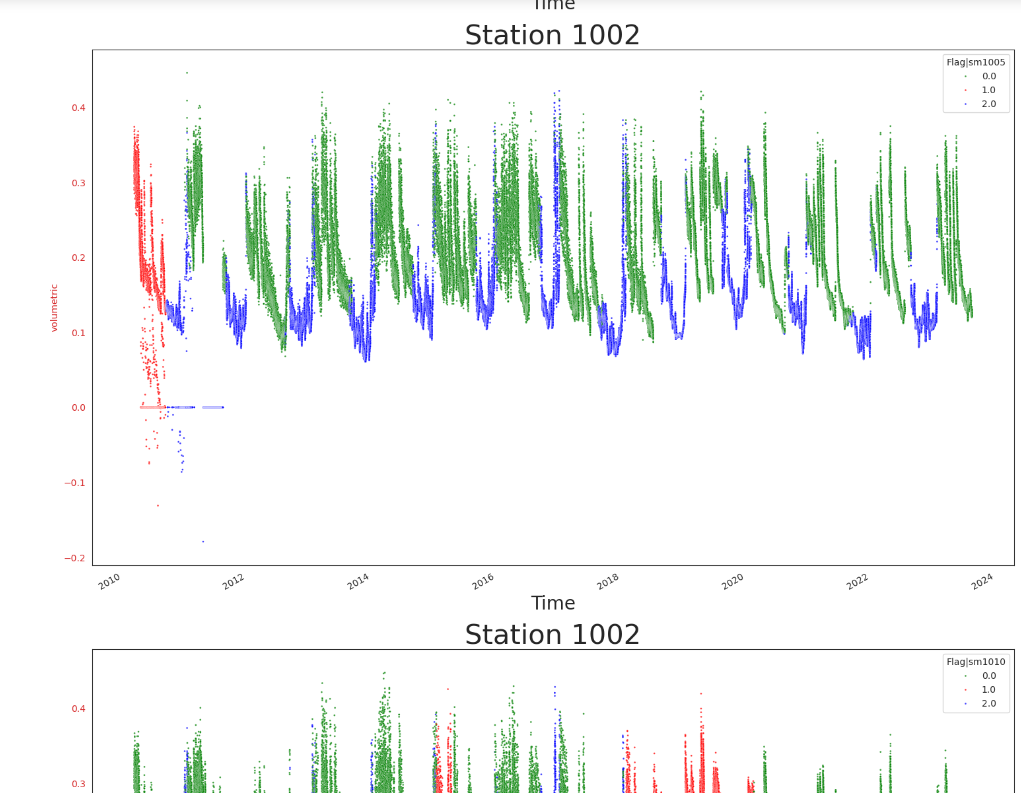

In [ ]:
#Plot the predicted and actual flags for preprocessed data
def plot_everything(station,df):
    station_df = df.copy()
    #station_df['UTC_Start'] = pd.to_datetime(station_df['UTC_Start'])
    # None values in variable
    sensors = ['sm1005','sm1010','sm1020','sm1050','sm1100','sm2005','sm2010','sm2020','sm2050','sm2100','sm3005','sm3010','sm3020','sm3050','sm3100']
    for sensor in sensors:
        station_df.loc[station_df[f'Volumetric|{sensor}'] <-5, f'Volumetric|{sensor}'] = 0
        station_df.loc[station_df[f'Volumetric|{sensor}'] > 2, f'Volumetric|{sensor}'] = 0
    station_df.loc[station_df['Precipitation'] < -2, 'Precipitation'] = 0
    station_df.loc[station_df['Precipitation'] > 30, 'Precipitation'] = 0
    fig, ax = plt.subplots(31, 1, figsize=(15, 145))

    color = 'tab:red'
    sns.scatterplot(ax=ax[0], data=station_df,x='UTC_Start', y='Precipitation',  color=color, marker='x', s=25, alpha=0.75)
    ax[0].set_ylabel('Precipitation', color=color)
    ax[0].tick_params(axis='y', labelcolor=color)
    ax[0].set_xlabel('Time', fontsize = 20)
    ax[0].tick_params(axis='x', labelrotation=30)
    ax[0].set_title(f'Station {station}', fontsize = 30)
    count = 0
    for i in range(1,30,2):
        sns.scatterplot(ax=ax[i], data=station_df,x='UTC_Start', y=f'Volumetric|{sensors[count]}',hue = f'Flag|{sensors[count]}',palette={0:"green",1:"red",2:"blue"}, s=4, alpha=0.75)
        ax[i].set_ylabel('volumetric', color=color)
        ax[i].tick_params(axis='y', labelcolor=color)
        ax[i].set_xlabel('Time', fontsize = 20)
        ax[i].tick_params(axis='x', labelrotation=30)
        ax[i].set_title(f'Station {station}', fontsize = 30)

        sns.scatterplot(ax=ax[i+1], data=station_df,x='UTC_Start', y=f'Volumetric|{sensors[count]}',hue = f'predicted_Flag|{sensors[count]}',palette={0:"green",1:"red",2:"blue"}, s=4, alpha=0.75)
        ax[i+1].set_ylabel('volumetric', color=color)
        ax[i+1].tick_params(axis='y', labelcolor=color)
        ax[i+1].set_xlabel('Time', fontsize = 20)
        ax[i+1].tick_params(axis='x', labelrotation=30)
        ax[i+1].set_title(f'Station {station}', fontsize = 30)
        count = count + 1
    plt.tight_layout()
    plt.show()

In [ ]:
for file in [valid_pred_filelist[0]]:
    print(file)
    df = pd.read_parquet(file, engine='pyarrow')
    plot_everything(file[-12:-8], df)

sample output 

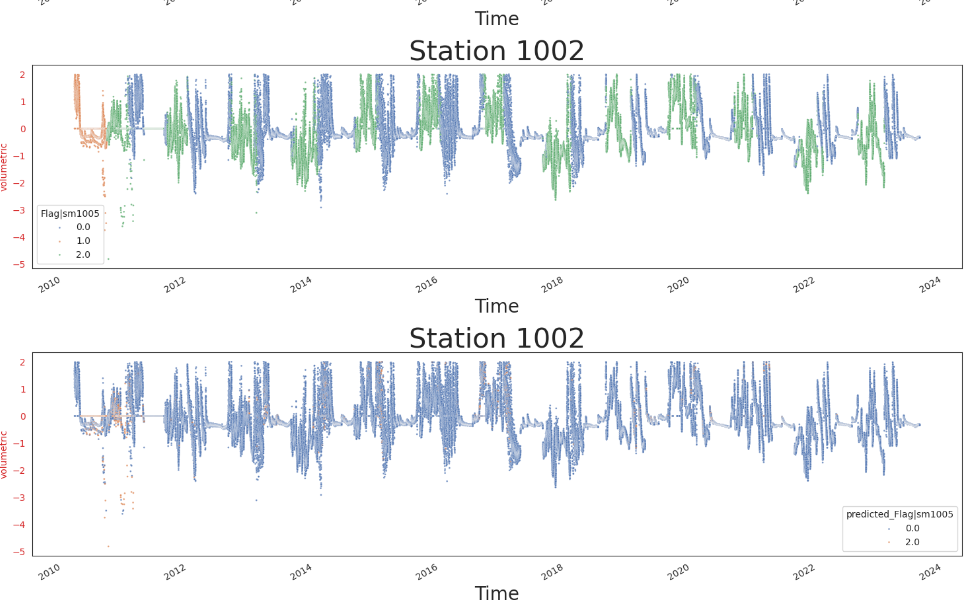

## Test the model and data loader to be used

In [ ]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import auc, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.backend import clear_session
import datetime as dt

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:

img_size = (128,16)
def create_model(n_classes, n_features):
    inputs = tf.keras.layers.Input((sequence_length, n_features) + (1,))
    
    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = tf.keras.layers.BatchNormalization()(c1)
    r1 = tf.keras.layers.ReLU()(b1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)
    
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = tf.keras.layers.BatchNormalization()(c2)
    r2 = tf.keras.layers.ReLU()(b2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
     
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = tf.keras.layers.BatchNormalization()(c3)
    r3 = tf.keras.layers.ReLU()(b3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
     
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = tf.keras.layers.BatchNormalization()(c4)
    r4 = tf.keras.layers.ReLU()(b4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
     
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)
    
     
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)
    
     
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.ReLU()(u8)
     
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.ReLU()(u9)
    
     
    outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation="softmax")(u9)
    #o = tf.keras.layers.Reshape((2048,3))(outputs)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    #print(model.summary())
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])#,sample_weight_mode="temporal" )
    return model
#tf.keras.utils.plot_model(model, "model.png")

In [ ]:
model = create_model(n_classes,n_features)
sample_weight = np.zeros((1623,2048))

In [ ]:
flag_columns = ['Flag|sm1005', 'Flag|sm1010', 'Flag|sm1020', 'Flag|sm1050', 'Flag|sm1100',
       'Flag|sm2005', 'Flag|sm2010', 'Flag|sm2020', 'Flag|sm2050',
       'Flag|sm2100', 'Flag|sm3005', 'Flag|sm3010', 'Flag|sm3020',
       'Flag|sm3050', 'Flag|sm3100', 'Precipitation|Flag']#, 'Wetness2|Flag','Precipitation|Flag']
value_columns = ['Volumetric|sm1005', 'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050', 'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010', 'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100', 'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020', 'Volumetric|sm3050', 'Volumetric|sm3100','Precipitation']#, 'Wetness2', 'Temperature']


In [ ]:
train_metrics = {}
test_metrics = {}

Initially data was fed to the FCN model station wise. However, this does not shuffle thed ata and thus leads to poor performance. Next the order of stations was shuffled in each epoch . However, data with the station was still fed in the same order. Finally, data across stations are shuffled by combining the individual datasets and using dataset.shuffle'


In [ ]:
# Combining datasets from all files so batches can be shuffled before feeding to the model across stations
c =0 
datasets = []

for file in valid_filelist:
    c = c + 1
    print("train file: ", file)
    df = pd.read_parquet(file,engine='pyarrow')
    input_ds = keras.preprocessing.timeseries_dataset_from_array(
    df[value_columns],
    targets=None,
    sequence_length=sequence_length,
    sequence_stride=8,
    sampling_rate=1,
    #sampling_rate=step,
    batch_size=batch_size,
    )
    #print(df.shape)
    sample_weight = np.ones(shape=(len(df[flag_columns]),))
    #print(sample_weight.shape)
    for col in flag_columns:
        sample_weight[df[col]== 1] = 1
    #print(sample_weight.shape)
    sample_weight = tf.data.Dataset.from_tensor_slices(sample_weight)
    #sample_weight[df[flag_columns].values.reshape(-1) == 1] = 10.0
    targetsdf = df[flag_columns]
    
    target_ds = tf.keras.utils.timeseries_dataset_from_array(
    targetsdf, targets=None, sequence_length=sequence_length,
      sequence_stride=8, sampling_rate=1, batch_size=batch_size)
    
    train_ds = tf.data.Dataset.zip((input_ds,target_ds))
    datasets.append(train_ds)
    del [df,targetsdf, input_ds,target_ds,train_ds]
    if c == 4:
        break

combined_dataset = datasets[0]
for dataset in datasets[1:]:
    combined_dataset = combined_dataset.concatenate(dataset)
combined_dataset = combined_dataset.shuffle(buffer_size=len(combined_dataset) ,reshuffle_each_iteration=True)
print(len(combined_dataset))

In [ ]:
#Performing the same batch shuffling for validation data
datasets = []
c = 0
for file in valid_filelist:
    c = c + 1
    print("train file: ", file)
    df = pd.read_parquet(file,engine='pyarrow')
    input_ds = keras.preprocessing.timeseries_dataset_from_array(
    df[value_columns],
    targets=None,
    sequence_length=sequence_length,
    sequence_stride=8,
    sampling_rate=1,
    #sampling_rate=step,
    batch_size=batch_size,
    )

    targetsdf = df[flag_columns]
    
    target_ds = tf.keras.utils.timeseries_dataset_from_array(
    targetsdf, targets=None, sequence_length=sequence_length,
      sequence_stride=8, sampling_rate=1, batch_size=batch_size)
    
    train_ds = tf.data.Dataset.zip(input_ds,target_ds)
    datasets.append(train_ds)
    del [df,targetsdf, input_ds,target_ds,train_ds]
    if c == 2:
        break

combined_val_dataset = datasets[0]
for dataset in datasets[1:]:
    combined_val_dataset = combined_val_dataset.concatenate(dataset)
combined_val_dataset = combined_val_dataset.shuffle(buffer_size=len(combined_val_dataset) ,reshuffle_each_iteration=True)

In [ ]:
combined_dataset = combined_dataset.shuffle(buffer_size=100 ,reshuffle_each_iteration=True)
combined_val_dataset = combined_val_dataset.shuffle(buffer_size=100 ,reshuffle_each_iteration=True)

In [ ]:
#Testing the mdoel
model = create_model(n_classes,n_features)
history = model.fit(
        combined_dataset, epochs=3, validation_data = combined_val_dataset)
print("hist: ",history.history)
print(history.history.values)

In [ ]:
valid_filelist

In [ ]:
for file in valid_filelist:
    df = pd.read_parquet(file, engine='pyarrow')
    input_ds = keras.preprocessing.timeseries_dataset_from_array(
    df[value_columns],
    targets=None,
    sequence_length=sequence_length,
    sequence_stride=sequence_length,
    sampling_rate=1,
    #sampling_rate=step,
    batch_size=batch_size,
    )
                                                  
    targetsdf = df[flag_columns]
                                                             
    target_ds = tf.keras.utils.timeseries_dataset_from_array(
    targetsdf, targets=None, sequence_length=sequence_length,
    sequence_stride=sequence_length, sampling_rate=1, batch_size=batch_size)
                                                                               
    train_ds = tf.data.Dataset.zip(input_ds,target_ds)
    print("train_ds: ", len(train_ds))
    print("df: ",len(df))
    print(df.columns)
    res = model.predict(train_ds)
    print("res: ",len(res))
    break

In [ ]:
res.shape

In [ ]:
res = res.argmax(axis=-1)
res = res.reshape(-1,16)

In [ ]:
res.shape

In [ ]:
for i in range(len(df)-len(res)):
    res = np.append(res,[[0]*16],axis=0)
res.shape


In [ ]:
res = model.predict(combined_val_dataset)
res.argmax(axis=-1).reshape(-1).shape

In [ ]:
res.argmax(axis=-1).shape

In [ ]:
true = []
pred = []
count = 0
for batch in train_ds:
    count = count + 1
    inputs, targets = batch
    results = model.predict(inputs)
    true.extend(targets.numpy().reshape(-1))
    pred.extend(results.argmax(axis=-1).reshape(-1))
print(count)
print(len(true))
print(len(pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, pred, labels=[0,1,2])   #targets.numpy().reshape(-1), results.argmax(axis=-1).reshape(-1), labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot()
plt.show()

In [ ]:
import seaborn as sns
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
fgi = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
fig.get_figure().savefig('confusion_matrix_epoch25_shuffle_stations.png')

In [ ]:
results = model.predict(train_ds)
print("Predict shape:",results.argmax(axis=-1).reshape(-1).shape)

In [ ]:
print("Predict shape:",results.argmax(axis=-1).reshape(-1).shape)

In [ ]:
results.shape

In [ ]:
print("Input ")
#cmap = plt.get_cmap('RdBu', 3)
plt.matshow(inputs[33][:,:15])
#cax = plt.colorbar(mat, ticks=np.arange(3))
plt.colorbar(orientation='vertical')
#plt.savefig("sample.
plt.show()

In [ ]:
print("true output: ")
cmap = plt.get_cmap('RdBu', 2)
mat = plt.matshow(targets[33],cmap=cmap)
cax = plt.colorbar(mat, ticks=np.arange(3))
#plt.colorbar(orientation='vertical')
plt.show()

### Trying to change FCN architecture for input shape from 128, 16 to 126, 18

In [ ]:
n_features = 18
sequence_length = 126

def create_model2(n_classes, n_features):
    inputs = tf.keras.layers.Input((sequence_length, n_features, 1))
    
    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = tf.keras.layers.BatchNormalization()(c1)
    r1 = tf.keras.layers.ReLU()(b1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)
    
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = tf.keras.layers.BatchNormalization()(c2)
    r2 = tf.keras.layers.ReLU()(b2)
    p2 = tf.keras.layers.MaxPooling2D((3, 3))(r2)
     
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = tf.keras.layers.BatchNormalization()(c3)
    r3 = tf.keras.layers.ReLU()(b3)
    p3 = tf.keras.layers.MaxPooling2D((3, 3))(r3)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(3, 3), padding='same')(p3)
    u6 = tf.keras.layers.concatenate([u6[:, :, :64, :], c3], axis=3)
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)
    
    u7 = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(3, 3), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7[:, :, :128, :], c2], axis=3)
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)

    u8 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = tf.keras.layers.concatenate([u8[:, :, :256, :], c1], axis=3)
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.ReLU()(u8)
    '''
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = tf.keras.layers.BatchNormalization()(c4)
    r4 = tf.keras.layers.ReLU()(b4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6[:, :, :64, :], c3], axis=3)
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7[:, :, :128, :], c2], axis=3)
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)
    
    #u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
    #u8 = tf.keras.layers.concatenate([u8[:, :, :256, :], c1], axis=3)
    #u8 = tf.keras.layers.BatchNormalization()(u8)
    #u8 = tf.keras.layers.ReLU()(u8)
     
    #u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
    #u9 = tf.keras.layers.concatenate([u9[:, :, :512, :], c1], axis=3)
    #u9 = tf.keras.layers.BatchNormalization()(u9)
    #u9 = tf.keras.layers.ReLU()(u9)
    '''
    outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation="softmax")(u8)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    print(model.summary())
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [ ]:
model = create_model2(n_classes,18)

In [ ]:
flag_columns = ['Flag|sm1005', 'Flag|sm1010', 'Flag|sm1020', 'Flag|sm1050', 'Flag|sm1100',
       'Flag|sm2005', 'Flag|sm2010', 'Flag|sm2020', 'Flag|sm2050',
       'Flag|sm2100', 'Flag|sm3005', 'Flag|sm3010', 'Flag|sm3020',
       'Flag|sm3050', 'Flag|sm3100', 'Temperature|Flag','Precipitation|Flag','dummy|Flag']
value_columns = ['Volumetric|sm1005', 'Volumetric|sm1010', 'Volumetric|sm1020', 'Volumetric|sm1050', 'Volumetric|sm1100', 'Volumetric|sm2005', 'Volumetric|sm2010', 'Volumetric|sm2020', 'Volumetric|sm2050', 'Volumetric|sm2100', 'Volumetric|sm3005', 'Volumetric|sm3010', 'Volumetric|sm3020', 'Volumetric|sm3050', 'Volumetric|sm3100','Temperature','Precipitation','dummy']


In [ ]:
c =0 
datasets = []
n_features = 18
sequence_length = 126

for file in filelist:
    c = c + 1
    print("train file: ", file)
    df = pd.read_parquet(file,engine='pyarrow')
    df['dummy'] = 0
    df['dummy|Flag'] = 0
    input_ds = keras.preprocessing.timeseries_dataset_from_array(
    df[value_columns],
    targets=None,
    sequence_length=sequence_length,
    sequence_stride=8,
    sampling_rate=1,
    #sampling_rate=step,
    batch_size=batch_size,
    )

    targetsdf = df[flag_columns]
    
    target_ds = tf.keras.utils.timeseries_dataset_from_array(
    targetsdf, targets=None, sequence_length=sequence_length,
      sequence_stride=8, sampling_rate=1, batch_size=batch_size)
    
    train_ds = tf.data.Dataset.zip(input_ds,target_ds)
    datasets.append(train_ds)
    del [df,targetsdf, input_ds,target_ds,train_ds]
    if c == 4:
        break

combined_dataset = datasets[0]
for dataset in datasets[1:]:
    combined_dataset = combined_dataset.concatenate(dataset)
combined_dataset = combined_dataset.shuffle(buffer_size=len(combined_dataset) ,reshuffle_each_iteration=True)
print(len(combined_dataset))

In [ ]:
datasets = []
c = 0
n_features = 18
sequence_length = 126

for file in filelist:
    c = c + 1
    print("train file: ", file)
    df = pd.read_parquet(file,engine='pyarrow')
    df['dummy'] = 0
    df['dummy|Flag'] = 0
    input_ds = keras.preprocessing.timeseries_dataset_from_array(
    df[value_columns],
    targets=None,
    sequence_length=sequence_length,
    sequence_stride=8,
    sampling_rate=1,
    #sampling_rate=step,
    batch_size=batch_size,
    )

    targetsdf = df[flag_columns]
    
    target_ds = tf.keras.utils.timeseries_dataset_from_array(
    targetsdf, targets=None, sequence_length=sequence_length,
      sequence_stride=8, sampling_rate=1, batch_size=batch_size)
    
    train_ds = tf.data.Dataset.zip(input_ds,target_ds)
    datasets.append(train_ds)
    del [df,targetsdf, input_ds,target_ds,train_ds]
    if c == 2:
        break

combined_val_dataset = datasets[0]
for dataset in datasets[1:]:
    combined_val_dataset = combined_val_dataset.concatenate(dataset)
combined_val_dataset = combined_val_dataset.shuffle(buffer_size=len(combined_val_dataset) ,reshuffle_each_iteration=True)

In [ ]:
n_features = 18
sequence_length = 126
n_classes = 3
model = create_model2(n_classes,n_features)
history = model.fit(
        combined_dataset, epochs=3, validation_data = combined_val_dataset,class_weight={0:1,1:100,2:10})
print("hist: ",history.history)
print(history.history.values)

## Plotting metrics from resulting metrics values 

In [ ]:
import ast

In [ ]:
#Plot train metrics
f = open("./metrics/train_unet_metrics.txt")
content = f.read()
content = content.split("\n")
len(content)

In [ ]:
count = 0
train_metrics_acc = {}
train_metrics_miou = {}
for i in range(0,len(content)-102,102):
    count = count + 1
    #print(i)
    for j in range(2,101):
        file_name = ast.literal_eval(content[i+j])['file_name']
        accuracy = ast.literal_eval(content[i+j])['accuracy'][0]
        miou = ast.literal_eval(content[i+j])['miou'][0]
        if file_name in train_metrics_acc:
            train_metrics_acc[file_name].append(accuracy)
        else:
            train_metrics_acc[file_name] = [accuracy]
        if file_name in train_metrics_miou:
            train_metrics_miou[file_name].append(miou)
        else:
            train_metrics_miou[file_name] = [miou]


In [ ]:
train_metrics_acc.keys()

In [ ]:
from bokeh.palettes import Spectral4,Spectral10
from bokeh.plotting import figure, show
p = figure(width=1000, height=800)
p.title.text = "Click on legend entries to hide the corresponding lines"

for key,values,color in zip(list(train_metrics_acc.keys())[15:25],list(train_metrics_acc.values())[15:25],Spectral10):
    df = pd.DataFrame(values)
    df["epoch"] = df.index
    #print(df[0].head())
    p.line(df["epoch"], df[0], line_width=2, color=color, alpha=0.8, legend_label=key)
    #plt.plot(range(0,len(values)), values)
p.legend.location = "top_left"
p.legend.click_policy = "hide"  # 🔁 change to "mute" to mute the lines instead of hiding them

show(p)

In [ ]:
#MIOU
from bokeh.palettes import Spectral4,Spectral10
from bokeh.plotting import figure, show
p = figure(width=1000, height=1500)
p.title.text = "Click on legend entries to hide the corresponding lines"

for key,values,color in zip(list(train_metrics_miou.keys())[:10],list(train_metrics_miou.values())[:10],Spectral10):
    df = pd.DataFrame(values)
    df["epoch"] = df.index
    #print(df[0].head())
    p.line(df["epoch"], df[0], line_width=2, color=color, alpha=0.8, legend_label=key)
    #plt.plot(range(0,len(values)), values)
p.legend.location = "top_left"
p.legend.click_policy = "hide"  # 🔁 change to "mute" to mute the lines instead of hiding them

show(p)

In [ ]:
f = open("./metrics/v4_fixed_data_no_shuffle_metrics/valid_unet_metrics.txt")
content = f.read()
content = content.split("\n")
len(content)

In [ ]:
count = 0
valid_metrics_acc = {}
valid_metrics_miou = {}
for i in range(0,len(content)-13,13):
    count = count + 1
    #print(i)
    for j in range(2,12):
        #print(content[i+j].split(",")[3][:-1])
    #break
        file_name = content[i+j].split(",")[3][:-1]
        accuracy = float(content[i+j].split(",")[1])
        miou = float(content[i+j].split(",")[2])
        if file_name in valid_metrics_acc:
            valid_metrics_acc[file_name].append(accuracy)
        else:
            valid_metrics_acc[file_name] = [accuracy]
        if file_name in valid_metrics_miou:
            valid_metrics_miou[file_name].append(miou)
        else:
            valid_metrics_miou[file_name] = [miou]

In [ ]:
from bokeh.palettes import Spectral4,Spectral10
from bokeh.plotting import figure, show
p = figure(width=1000, height=800,y_range=(0, 1))
p.title.text = "Click on legend entries to hide the corresponding lines"

for key,values,color in zip(list(valid_metrics_acc.keys()),list(valid_metrics_acc.values()),Spectral10):
    df = pd.DataFrame(values)
    df["epoch"] = df.index
    #print(df[0].head())
    p.line(df["epoch"], df[0], line_width=2, color=color, alpha=0.8, legend_label=key)
    #plt.plot(range(0,len(values)), values)
p.legend.location = "top_left"
p.legend.click_policy = "hide"  # 🔁 change to "mute" to mute the lines instead of hiding them

show(p)

For metrics when data is shuffled across batches, there is no longer per station metrics. Thus this needs to be read and plotted differently

In [ ]:
f = open("./UNET/fix station shuffle batch across stations/with precip and temp/train_val_unet_metrics.txt")
content = f.read()
content = content.split("\n")[2]
content

In [ ]:
ast.literal_eval(content).keys()

In [ ]:
from bokeh.palettes import Spectral4,Spectral10
from bokeh.plotting import figure, show
p = figure(width=1000, height=800)
p.title.text = "Click on legend entries to hide the corresponding lines"

for key,values,color in zip(list(ast.literal_eval(content).keys()),list(ast.literal_eval(content).values()),Spectral10):
    df = pd.DataFrame(values)
    df["epoch"] = df.index
    #print(df[0].head())
    p.line(df["epoch"], df[0], line_width=2, color=color, alpha=0.8, legend_label=key)
    #plt.plot(range(0,len(values)), values)
p.legend.location = "top_left"
p.legend.click_policy = "hide"  # 🔁 change to "mute" to mute the lines instead of hiding them

show(p)